<a href="https://colab.research.google.com/github/pejmanrasti/From_Shallow_to_Deep/blob/main/Classification_shallow_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Specific concepts that will be covered:
In the process, we will build practical experience and develop intuition around the concepts classification



## We will follow the general machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build our models
4. Train our models
5. Test our models
6. Improve our model/Repeat the process

<hr>

**Before you begin**

Before running the code in this notebook, reset the runtime by going to **Kernel -> Restart & clear output** in the menu above. If you have been working through several notebooks, this will help you avoid reaching memory limits.

© Aurélien Géron

# Importing Libraries

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
Our_Task = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", Our_Task)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Reading and undrestanding our data

Our goal is to construct and train a classification mosel on thousands of images of handwritten digits so that it may successfully identify others when presented. The data that will be incorporated is the MNIST database which contains 60,000 images for training and 10,000 test images.


<img src="https://camo.githubusercontent.com/01c057a753e92a9bc70b8c45d62b295431851c09cffadf53106fc0aea7e2843f/687474703a2f2f692e7974696d672e636f6d2f76692f3051493378675875422d512f687164656661756c742e6a7067" >

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [ ]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [ ]:
print(y.shape)

(70000,)


Saving figure Random_digit_plot


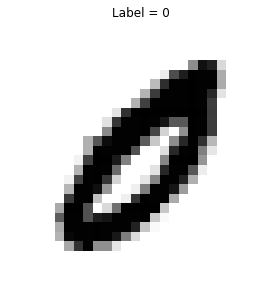

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import random 

n = random.randint(0,70000)
random_digit = X[n]
random_digit_2D = random_digit.reshape(28, 28)
plt.imshow(random_digit_2D, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("Random_digit_plot")
plt.title("Label = " + y[n])
plt.show()

In [ ]:
y = y.astype(np.uint8)

In [ ]:
X_train, X_test, y_train, y_test = X[:55000], X[55000:], y[:55000], y[55000:]

# Binary classifier

In [ ]:
# Make all labels equal to five as true and the rest as fault 
y_keep_7 = (y_train == 7)
y_test_keep_7 = (y_test == 7)

There are a couple of classifiers available for this task but we would start with the [stochastic gradient descent (SGD)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) classifier.

In [ ]:

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_keep_7)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
sgd_clf.predict([random_digit])

array([False])

Cross-validation is a statistical method used to estimate the skill of machine learning models.

It is commonly used in applied machine learning to compare and select a model for a given predictive modeling problem because it is easy to understand, easy to implement, and results in skill estimates that generally have a lower bias than other methods.


<img src=https://scikit-learn.org/stable/_images/grid_search_cross_validation.png>

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_keep_7, cv=5, scoring="accuracy")

array([0.98345455, 0.98181818, 0.97809091, 0.97545455, 0.95536364])

*   KFold is a cross-validator that divides the dataset into k folds.
*   Stratified is to ensure that each fold of dataset has the same proportion of observations with a given label



In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_keep_7):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_keep_7[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_keep_7[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9659090909090909
0.9796363636363636
0.978
0.9761818181818182
0.9748181818181818


In [ ]:
from sklearn.base import BaseEstimator
class Never7Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [ ]:
never_7_clf = Never7Classifier()
cross_val_score(never_7_clf, X_train, y_keep_7, cv=5, scoring="accuracy")

array([0.89390909, 0.89845455, 0.89654545, 0.89781818, 0.89490909])

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_keep_7, cv=5)

A confusion matrix is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. This is the key to the confusion matrix.
<img src=http://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix_files/confusion_matrix_1.png >

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_keep_7, y_train_pred)

array([[48565,   733],
       [  651,  5051]])

In [ ]:
y_train_perfect_predictions = y_keep_7  # pretend we reached perfection
confusion_matrix(y_keep_7, y_train_perfect_predictions)

array([[49298,     0],
       [    0,  5702]])

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_keep_7, y_train_pred)

0.8732710926694329

In [ ]:
cm = confusion_matrix(y_keep_7, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8732710926694329

In [ ]:
recall_score(y_keep_7, y_train_pred)

0.8858295334970185

In [ ]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.8858295334970185

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_keep_7, y_train_pred)

0.8795054849381856

In [ ]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.8795054849381856

In [ ]:
y_scores = sgd_clf.decision_function([random_digit])
y_scores

array([-19963.48783553])

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [ ]:
y_some_digit_pred

array([False])

In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

# Multiclass classification

Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are capable of handling multiple classes directly. Others (such as Support Vector Machine classifiers or Linear classifiers) are strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classification using multiple binary classifiers.

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([random_digit])

array([7], dtype=uint8)

In [ ]:
some_digit_scores = svm_clf.decision_function([random_digit])
some_digit_scores

array([[ 3.93672053,  8.19324105,  4.98585718,  1.87180719,  7.1107916 ,
         0.85998001,  2.88509577,  9.19744483, -0.18355263,  6.01561605]])

In [ ]:
np.argmax(some_digit_scores)

7

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
svm_clf.classes_[5]

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([random_digit])

array([7], dtype=uint8)

In [ ]:
len(ovr_clf.estimators_)

10

In [ ]:
sgd_clf.fit(X_train, y_train) #trains the SGDClassifier on the training set
sgd_clf.predict([random_digit])

#Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the
#image, and selected the class with the highest score.

array([0], dtype=uint8)

In [ ]:
# show the result of all binary classifications

sgd_clf.decision_function([random_digit])

array([[  6259.63334664, -37298.43856375,  -8221.40135485,
        -16590.86548681, -17298.58197003, -12869.84044701,
        -24601.80299109, -31061.2490878 ,  -9220.59195893,
        -13110.9961844 ]])

**Warning**: the following two cells may take close to 30 minutes to run, or more depending on your hardware.

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87580452, 0.8618884 , 0.87356134])

One of the most important transformations you need to apply to your data is feature scaling. With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales.
There are two common ways to get all attributes to have the same scale: min-max scaling and standardization

Min-max: they end up ranging from 0 to 1

Standardization: first it subtracts the mean value, and then it divides by the standard deviation.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

In [ ]:
# Your Task, Train a random Forest classifier on our data
from sklearn.ensemble import RandomForestClassifier


# Error analysis

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5122,    0,   20,    7,    8,   51,   34,    5,  186,    1],
       [   1, 5904,   37,   23,    3,   45,    3,    6,  180,   10],
       [  25,   27, 4791,   84,   61,   28,   68,   38,  332,   11],
       [  21,   16,  107, 4798,    1,  206,   24,   41,  338,   70],
       [  12,   12,   42,    9, 4762,   11,   35,   18,  277,  165],
       [  27,   15,   31,  153,   50, 4088,   72,   17,  446,   64],
       [  28,   15,   42,    2,   44,   91, 5093,    6,  114,    1],
       [  16,   11,   49,   28,   47,   10,    4, 5152,  158,  227],
       [  18,   58,   44,   88,    3,  112,   27,    7, 4954,   46],
       [  23,   20,   28,   62,  118,   30,    1,  169,  292, 4723]])

In [ ]:
# since sklearn 0.22, you can use sklearn.metrics.plot_confusion_matrix()
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Saving figure confusion_matrix_plot


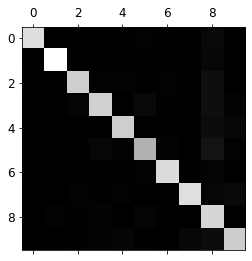

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


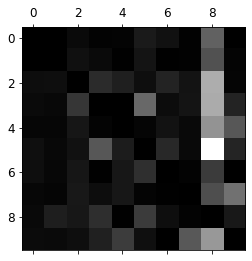

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [ ]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure error_analysis_digits_plot


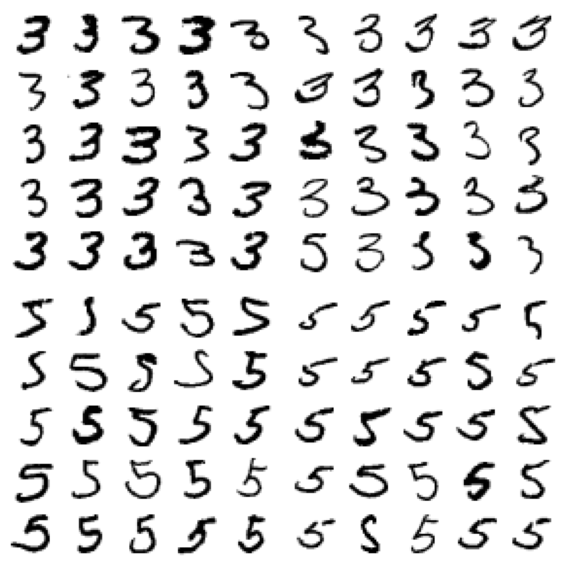

In [ ]:

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

# Multilabel classification

In some cases you may want your classifier to output multiple classes for each instance.

In [ ]:
#This block creates a y_multilabel array containing two target labels for each digit
#image: the first indicates whether or not the digit is large (7, 8, or 9) and the second
#indicates whether or not it is odd.

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
print(y[n]) #our random digit
knn_clf.predict([random_digit])

0


array([[False, False]])

**Warning**: the following cell may take a very long time (possibly hours depending on your hardware).

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

# Multioutput classification
It is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

Saving figure noisy_digit_example_plot


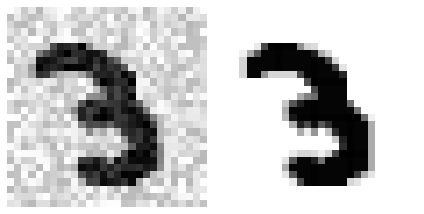

In [ ]:
some_index = 8
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

Saving figure cleaned_digit_example_plot


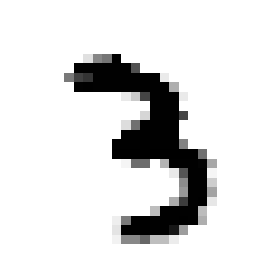

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

In [ ]:
# Task: Re-do the classification process on the Cifar-10 database
from tensorflow.keras.datasets import cifar10
(train_X, train_y), (test_X, test_y) = cifar10.load_data()